## PS 2 - Macro II
#### Marius Grünewald

In [120]:
# importing some utils
using LinearAlgebra, BenchmarkTools, Plots, LaTeXStrings

In [121]:
# some functions with element-wise operations; Outsourcing later work
# capital
f(x) = x.^alpha

# consumption
cons(x, x_2) = f(x) + (1-delta)*x - x_2

# utility
util(c) = log(c);

#### a)

In [122]:
# define parameters
alpha = 0.36; beta = 0.9; delta = 0.025;

#### b)
To solve for the steady state kapital accumulation, we start by deriving FOC's of <br>
   
<center>
$$
\begin{align}
V(k) = \max\{ u(f(k) + (1-\delta)k - k') + \beta V(k')\}
\end{align}
$$  &emsp;
</center>

There are two variables of interest $k$ and $k'$ <br>

$$
\begin{align*}
\frac{\partial V(k)}{\partial k'} &\implies u_{k'}(c) = \beta V_{k'}(k') \\
\frac{\partial V(k)}{\partial k} &\implies (f'(k) + (1-\delta))u_{k}(c) = \beta V_{k}(k)
\end{align*}
$$

Applying the functional forms such as $f'(k) = \alpha k^{\alpha -1}$ and $u'(c)=\frac{1}{c}$ yields
$$
\begin{align}
\frac{1}{c}  &=\beta V_{k'}(k') \label{eq1}\tag{1} \\
(\alpha k^{\alpha-1} + (1-\delta))\frac{1}{c} &= V_{k}(k) \label{eq2}\tag{2}
\end{align}
$$

By moving one state ahead, we can write ($\ref{eq2}$) as
$$ 
(\alpha (k')^{\alpha-1} + (1-\delta))\frac{1}{c'} = V_{k'}(k') \label{eq3}\tag{2'}
$$

Combining ($\ref{eq1}$) and ($\ref{eq3}$) via $V_{k'}(k')$ we obtain the difference equation
$$ \bigg(\alpha (k')^{\alpha-1} + (1-\delta)\bigg)\frac{1}{c'} = \frac{1}{\beta c} \label{eq4}\tag{3}$$

Solving for $k'$ and acknowledging the fact that in the steady-state $c=c'$, we are left with
$$ k' = \Big[\frac{\alpha\beta}{1 - \beta + \beta\delta} \Big]^{\frac{1}{1-\alpha}}$$

The stady-state capital accumulation.

In [123]:
k_ss = (alpha*beta/(1-beta+beta*delta))^(1/(1-alpha)) # compute steady

4.571028613291097

#### c), d), e) and f) in the function "value_function_iteration"

I defined the grid inside the function in an attempt to be able to dynamically calculate for differently sized grids. (completely commented cell)

In [124]:
function value_function_iteration(alpha=alpha, beta=beta, delta=delta, nkk=500, epsilon=0.001)
    
    grid_ = LinRange(0.9*k_ss, 1.1*k_ss, nkk) # define grid
    # intial guess
    V_g = zeros(nkk)
    # storage for updates
    V_g1 = zeros(nkk)
    # some parameters
    error_ = 1
    count = 0
    # start while-loop as long as still outside of margin of error
    while error_ > epsilon
        
        # loop over all of today's potential capital
        for i in 1:nkk 
            k_now = grid_[i] # current value
            V_store = zeros(500) # temp storage
            
            # loop over all of tomorrow'S potential capital
            for j in 1:nkk
                k_next = grid_[j] # one instance 
                c = cons(k_now, k_next) # current consumption
                # check whether combination is possible
                if c < 0
                    V_store[j] = 0 # if negative consumption define placeholder (maybe better: -inf?)
                else
                    V_store[j] = util(c) + beta*V_g[j] # otherwise current value obtained by cons.
                end
            end
            V_g1[i] = maximum(V_store) # take the optimal decision for tomorrow and any given value of today
        end
        count = count + 1 # increase count
        error_ = norm(V_g1 - V_g)/norm(V_g) # normalize and calculate error
        V_g = copy(V_g1) # update decisions
    end
    
return count, V_g;
end

value_function_iteration (generic function with 6 methods)

---
##### Next function is just a test to give the code a tweak

In [125]:
# Test to loop over grids - Chris: how would I store this correctly

function value_function_iteration_2(alpha=alpha, beta=beta, delta=delta, nkk=[500, 2])
    
    grid_count_res = []
    grid_value_matrix = []
    
    for grid_count in nkk
        
        k_ss = (alpha*beta/(1-beta+beta*delta))^(1/(1-alpha))
        grid_ = LinRange(0.9*k_ss, 1.1*k_ss, grid_count)
        V_g = zeros(grid_count)
        count = 0
        V_g1 = zeros(grid_count)
        eps = 0.001
        error_ = 1

        while error_ > eps
            for i in 1:grid_count
                k_now = grid_[i]
                V_store = zeros(grid_count)
                for j in 1:grid_count
                    k_next = grid_[j]
                    c = k_now^alpha + (1-delta)*k_now - k_next
                    if c < 0
                        V_store[j] = 0
                    else
                        V_store[j] = util(cons(k_now, k_next)) + beta*V_g[j]
                    end
                end
                V_g1[i] = maximum(V_store) 
            end
            count = count + 1
            error_ = norm(V_g1 - V_g)/norm(V_g)
            V_g = copy(V_g1)
        end
        push!(grid_count_res, count)
        push!(grid_value_matrix, V_g)
    end    
    
return grid_count_res, grid_value_matrix
end

value_function_iteration_2 (generic function with 5 methods)

---
##### Regular PS continues here

#### g)

In [126]:
function policy_func(alpha=alpha, beta=beta, delta=delta, nkk=500)
    
    grid_ = LinRange(0.9*k_ss, 1.1*k_ss, nkk) #set up grid
    policy_store = zeros(nkk) # create storage
    pc_index = zeros(nkk) #create storage
    
    # for any capital today
    for i in 1:nkk 
        k_now = grid_[i] # today capital instance
        policy_temp = zeros(nkk)
        
        # any given capital tomorrow
        for j in 1:nkk 
            k_next = grid_[j] # tomorrow capital instance
            policy_temp[j] = util(cons(k_now, k_next)) + beta*value_var[j] # policy for the given i-j combination
        end
        # Take optimal kapital for tomorrow given guess of today
        k_index = argmax(policy_temp)
        # Generate index of optimal kapital combinations
        pc_index[i] = k_index
        policy_store[i] = grid_[k_index] # store absolute values
    end
    return policy_store, pc_index
end

policy_func (generic function with 5 methods)

#### h)

In [127]:
function asset_path_func(n_sim=50, kapital=kapital, nkk=500)
    
    grid_ = LinRange(0.9*k_ss, 1.1*k_ss, nkk) #set up grid
    assets = zeros(n_sim) # storage
    assets_index = ones(n_sim) # storage with first element set
    assets[1] = grid_[1] # set first element
    
    # simulate next 49 periods of life (1+49=50)
    for t in 1:n_sim-1
        # optimal policy function given capital of today => optimal decision for subsequent periods (all)
        assets_index[t+1] = pc_index_test[Int.(assets_index[t])]
        # store associated level of capital
        assets[t+1] = kapital[Int.(assets_index[t+1])]
    end
    return assets
end

asset_path_func (generic function with 4 methods)

After having defined all necessary function, we can run them and get the numerical solutions.

In [128]:
# Run Value Function Iteration; Take time
@time begin
count_var, value_var = value_function_iteration();
end

 12.214398 seconds (157.72 M allocations: 2.780 GiB, 4.43% gc time, 6.42% compilation time)


(45, [4.421406007979981, 4.422764519550946, 4.4241225027616915, 4.425480096967153, 4.426837284046469, 4.428194011533171, 4.429550217729319, 4.430905964941516, 4.432261390127229, 4.433616407842521  …  5.041397924836084, 5.042579398463811, 5.043760519891035, 5.044941350753131, 5.04612181975025, 5.047302110278451, 5.04848209082455, 5.049661872628462, 5.050841299129187, 5.052020391080022])

Answer to i), the first part:
<ul>
<li>
    It took <i>45</i> iterations to converge </li>
<li>    
    <i>11.3</i> seconds were needed to converge
</li>
</ul>

In [129]:
# run Policy function; Take time just for fun
@time begin
kapital, pc_index_test = policy_func();
end

  0.581054 seconds (4.11 M allocations: 76.330 MiB, 3.59% gc time, 56.29% compilation time)


([4.163391793067744, 4.165223868664253, 4.167055944260762, 4.168888019857272, 4.170720095453781, 4.172552171050291, 4.1743842466468, 4.1743842466468, 4.1762163222433095, 4.178048397839819  …  4.962176753145867, 4.964008828742376, 4.965840904338886, 4.9676729799353945, 4.969505055531904, 4.969505055531904, 4.971337131128415, 4.973169206724924, 4.975001282321434, 4.9768333579179425], [28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 34.0, 35.0, 36.0  …  464.0, 465.0, 466.0, 467.0, 468.0, 468.0, 469.0, 470.0, 471.0, 472.0])

In [130]:
# Calculate capital accumulation over time
asset_path = asset_path_func();

#### i) - remaining parts

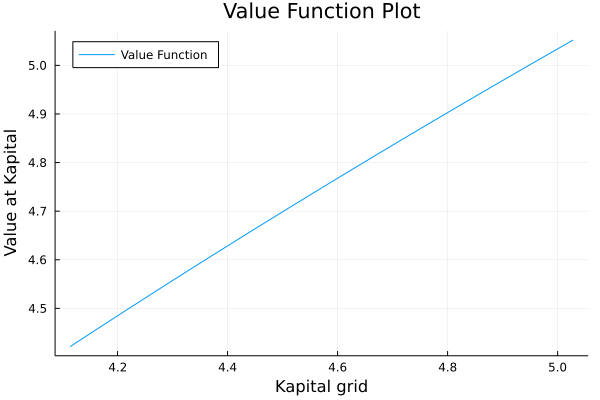

In [131]:
grid_ = LinRange(0.9*k_ss, 1.1*k_ss, 500) # since previously defined in function
plot(grid_, value_var, xlabel="Kapital grid", ylabel="Value at Kapital", label="Value Function",
    title="Value Function Plot", legend=:topleft)

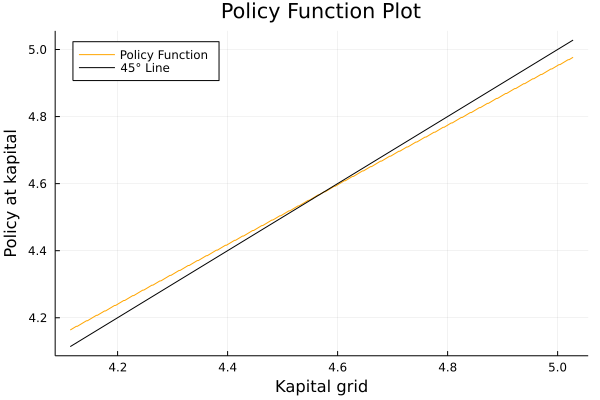

In [132]:
plot(grid_, kapital, color = :orange, xlabel="Kapital grid", ylabel="Policy at kapital", label="Policy Function")
plot!(grid_, grid_, color = :black, label="45° Line", title="Policy Function Plot", legend=:topleft)

In [133]:
# Compute savings
savings = zeros(500)
savings = kapital - grid_

500-element Vector{Float64}:
  0.04946604110575592
  0.04946604110575503
  0.04946604110575592
  0.04946604110575592
  0.04946604110575592
  0.04946604110575592
  0.04946604110575503
  0.04763396550924526
  0.047633965509246146
  0.047633965509246146
  0.047633965509246146
  0.047633965509246146
  0.047633965509246146
  ⋮
 -0.04946604110575503
 -0.04946604110575503
 -0.04946604110575503
 -0.04946604110575592
 -0.04946604110575503
 -0.04946604110575592
 -0.04946604110575592
 -0.051298116702265695
 -0.05129811670226392
 -0.05129811670226481
 -0.05129811670226392
 -0.05129811670226481

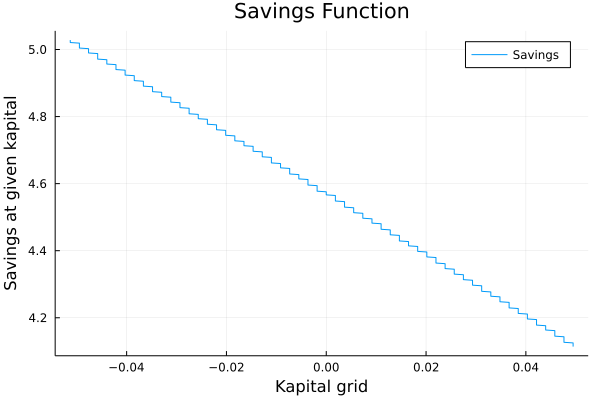

In [134]:
plot(savings, grid_, xlabel="Kapital grid", ylabel="Savings at given kapital", label="Savings",
    title="Savings Function")

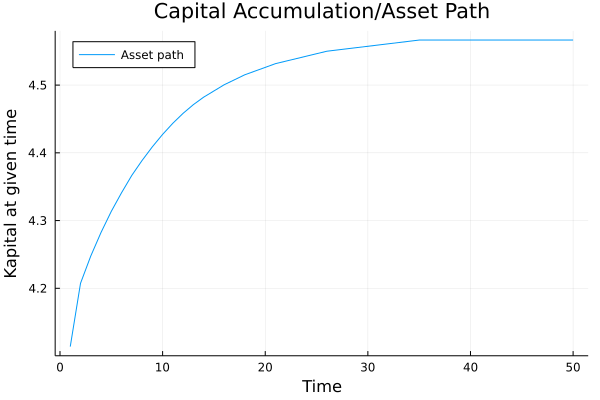

In [135]:
plot(1:50, asset_path, xlabel="Time", ylabel="Kapital at given time", label="Asset path",
    title="Capital Accumulation/Asset Path", legend=:topleft)

---
I would appreciate any suggestions on my code performance :)

In [136]:
# With varying grid size - little bonus
grid_count_res_, grid_value_matrix_ = value_function_iteration_2()

(Any[45, 45], Any[[4.421406007979981, 4.422764519550946, 4.4241225027616915, 4.425480096967153, 4.426837284046469, 4.428194011533171, 4.429550217729319, 4.430905964941516, 4.432261390127229, 4.433616407842521  …  5.041397924836084, 5.042579398463811, 5.043760519891035, 5.044941350753131, 5.04612181975025, 5.047302110278451, 5.04848209082455, 5.049661872628462, 5.050841299129187, 5.052020391080022], [4.414851838269337, 5.0453045914434504]])

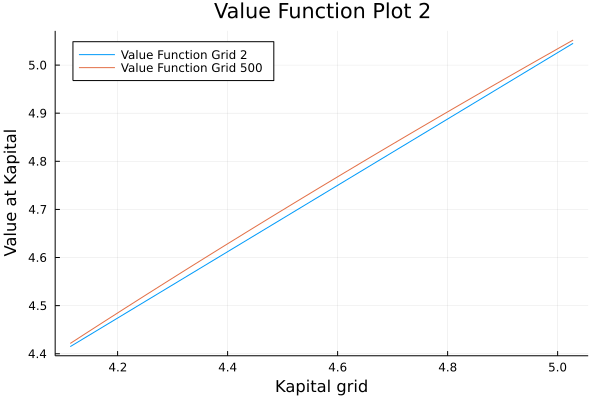

In [137]:
grid_2 = LinRange(0.9*k_ss, 1.1*k_ss, 2)
# grid size 2
plot(grid_2, grid_value_matrix_[2], xlabel="Kapital grid", ylabel="Value at Kapital", label="Value Function Grid 2",
    title="Value Function Plot 2", legend=:topleft)
# grid size 500
plot!(grid_, grid_value_matrix_[1], xlabel="Kapital grid", ylabel="Value at Kapital", label="Value Function Grid 500",
    title="Value Function Plot 2", legend=:topleft)